### Make a three-band image for Doodling
* Clip out ROI from DEM and 
* 
* Read in the DEM and normalize to 0-255
* Read in the ortho
    * Calculate panchromatic band
    * Calculate veg index band
    * Smooth and interpolate onto DEM grid
* Create 3-band image
* Export as jpg with aux.xml coordinate info

In [1]:
import os
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
import numpy as np
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Define functions for work on images

In [2]:
def normalized_uint8( a, nan_val = 0 ):
    amin = np.nanmin(a)
    amax = np.nanmax(a)
    a_shape = np.shape(a)
    ar = np.ravel(a)
    ar[np.where(np.isnan)] = nan_val
    ar = np.round(255*(ar-amin)/(amax-amin))
    return np.reshape(ar,a_shape).astype('uint8')


def GRRI_func(im):
    r, g, b = 0, 1, 2
    GRRI = im[:,:,g]/im[:,:,r]
    return GRRI


def GRVI_func(im):
    r, g, b = 0, 1, 2
    GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
    return GRVI


def Excess_funcs(im):
    '''
    Excess Red (ExR)
        Meyer, G. E., Hindman, T. W., and Laksmi, K. (1999). Machine vision
        detection parameters for plant species identification. in, eds.
        G. E. Meyer and J. A. DeShazer (Boston, MA), 327â€“335.
        doi:10.1117/12.336896.
    Excess Green (ExG)
        Woebbecke, D.M.; Meyer, G.E.; Von Bargen, K.; Mortensen, D.A.
        1995. Color Indices forWeed Identification Under Various Soil,
        Residue, and Lighting Conditions. Trans. ASAE, 38, 259-269.
    Excess Green minus R (ExGR)
        Neto, J.C. 2004. A combined statistical-soft computing approach
        for classification and mapping weed species in minimum -tillage
        systems. Ph.D. Thesis, University of Nebraska, Lincoln, Lincoln,
        NE, USA, August 2004.
        
    Thanks to Phil Wernette, USGS
    '''
    r = im[:,:,0]
    g = im[:,:,1]
    b = im[:,:,2]
    exr = 1.4*b-g
    exg = 2*g-r-b
    exgr = exg-exr
    return exr, exg, exgr


def gray_func(im):
    r, g, b = 0, 1, 2
    gray = np.round(  0.2989 * im[:,:,r]
                    + 0.5870 * im[:,:,g]
                    + 0.1140 * im[:,:,b])
    return gray.astype('uint8')


def twod_stats(im):
    print('dtype:', im.dtype, 'shape', im.shape)
    print('Number of nans:',np.sum(np.isnan(np.ravel(im))))
    print('2.5% {}, 97.5% {}'.format(np.nanpercentile(im, 2.5), np.nanpercentile(im, 97.5)))
    print('1% {}, 99% {}'.format(np.nanpercentile(im, 1), np.nanpercentile(im, 99)))
    print('min {}, max {}'.format(np.nanmin(im), np.nanmax(im)))
    print('median {}, mean {}'.format(np.nanpercentile(im, 50), np.nanmean(im)))

In [3]:
big_ortho_dir = 'C:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/'
big_ortho_fname = '20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif'

big_dem_dir = 'C:/crs/proj/2021_FloSupp_Release/Clipped_Final/'
big_dem_fname = '20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif'

out_dir = 'C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/jpeg_composites/'
ortho_fname = 'small_ortho.jpg'
dem_fname = 'small_dem.jpg'

# define a box
ulx=394500.
uly=3871680.
boxx = 250.
boxy = 200.

lrx=ulx+boxx
lry=uly-boxy

### Use gdal to convert the DEM from .tiff to .jpg and 1 m to 0.25 m

In [7]:
infile = big_dem_dir+big_dem_fname
outfile = out_dir+dem_fname
gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -tr 0.25 0.25 -r nearest -of JPEG  {} {}'.format(
    ulx, uly, lrx, lry, infile, outfile)
print(gdal_cmd)
os.system(gdal_cmd)
os.system('gdalinfo {}'.format(outfile))

gdal_translate -projwin 394500.0 3871680.0 394750.0 3871480.0 -b 1 -tr 0.25 0.25 -r nearest -of JPEG  C:/crs/proj/2021_FloSupp_Release/Clipped_Final/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_NAD83_2011_NAVD88_UTM18N_1m_cog.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/jpeg_composites/small_dem.jpg


0

### Try to open the small dem with gdal.
Not sure why the values are uint8. Maybe need to be more specific.

In [8]:
# open the small dem
ds = gdal.Open(out_dir+dem_fname, gdal.GA_ReadOnly)

dem = ds.GetRasterBand(1).ReadAsArray()
dem

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

### Instead, open the DEM with xarray

In [9]:
dsx = xr.open_dataset(out_dir+dem_fname)
dsx

<xarray.Dataset>
Dimensions:      (band: 1, x: 1000, y: 800)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 3.945e+05 3.945e+05 ... 3.947e+05 3.947e+05
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [10]:
el = np.squeeze(np.array(dsx.band_data))
twod_stats(el)

eln = normalized_uint8(el, nan_val = np.nan)
twod_stats(eln)

dtype: float32 shape (800, 1000)
Number of nans: 624
2.5% 1.0, 97.5% 4.0
1% 0.0, 99% 4.0
min 0.0, max 6.0
median 1.0, mean 1.622356653213501
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 42.0, 97.5% 170.0
1% 0.0, 99% 170.0
min 0, max 255
median 42.0, mean 68.68104


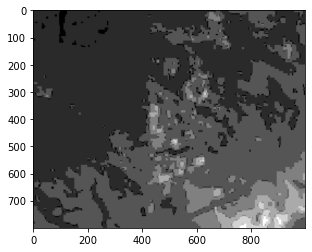

In [11]:
plt.imshow(eln, cmap='gray')

### Use Gdal to clip the same sub-region out of the big ortho

In [12]:
infile = big_ortho_dir+big_ortho_fname
outfile = out_dir+ortho_fname

gdal_cmd = 'gdal_translate -projwin {} {} {} {} -b 1 -b 2 -b 3 -of JPEG  {} {}'.format(ulx, uly, lrx, lry, infile, outfile)
print(gdal_cmd)
os.system(gdal_cmd)
os.system('gdalinfo {}'.format(outfile))

gdal_translate -projwin 394500.0 3871680.0 394750.0 3871480.0 -b 1 -b 2 -b 3 -of JPEG  C:/crs/proj/2019_DorianOBX/2021-07-27_FloSup_Products/ortho_cog/20190830_Ocracoke_Inlet_to_Ophelia_Inlet_RGBavg_NAD83_2011_UTM18_0.25m_cog.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/jpeg_composites/small_ortho.jpg


0

### Read in the small ortho

In [13]:
# open the small ortho
ds = gdal.Open(out_dir+ortho_fname, gdal.GA_ReadOnly)

# Allocate an array using the first band's datatype
image_datatype = ds.GetRasterBand(1).DataType

image = np.zeros((ds.RasterYSize, ds.RasterXSize, ds.RasterCount),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

# # Loop over all bands in dataset
for b in range(ds.RasterCount):
    band = ds.GetRasterBand(b + 1)   
    # Read in the band's data into the third dimension of our array
    image[:, :, b] = band.ReadAsArray()

print('Band 2.5% {}, 97.5% {}'.format(np.nanpercentile(image, 2.5), np.nanpercentile(image, 97.5)))
print('Band 1% {}, 99% {}'.format(np.nanpercentile(image, 1), np.nanpercentile(image, 99)))

print('Red band mean: {r}'.format(r=image[:, :, 0].mean()))

Band 2.5% 39.0, 97.5% 186.0
Band 1% 33.0, 99% 194.0
Red band mean: 95.825065


### Compute veg indices

In [14]:
GRRI = GRRI_func(image)
print('GRRI:')
twod_stats(GRRI)
print('\nGRRI_n')
GRRI_n = normalized_uint8( GRRI )
twod_stats(GRRI_n)

GRRI:
dtype: float64 shape (800, 1000)
Number of nans: 0
2.5% 0.9540229885057471, 97.5% 1.3095238095238095
1% 0.9404761904761905, 99% 1.3714285714285714
min 0.8135593220338984, max 5.25
median 1.0108695652173914, mean 1.0445999812659192

GRRI_n
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 8.0, 97.5% 29.0
1% 7.0, 99% 32.0
min 0, max 255
median 11.0, mean 13.2556675


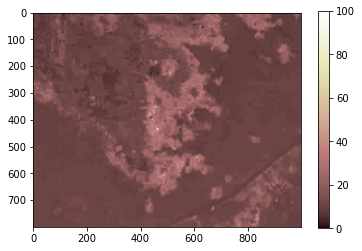

In [15]:
plt.imshow(GRRI_n, cmap = 'pink', vmin=0, vmax=100)
plt.colorbar()

In [16]:
twod_stats(image[:,:,0])
twod_stats(image[:,:,1])
twod_stats(image[:,:,2])

GRVI = GRVI_func(image)
twod_stats

dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 39.0, 97.5% 187.0
1% 34.0, 99% 195.0
min 4, max 213
median 87.0, mean 95.825065
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 48.0, 97.5% 187.0
1% 44.0, 99% 195.0
min 13, max 215
median 88.0, mean 98.10460625
dtype: uint8 shape (800, 1000)
Number of nans: 0
2.5% 34.0, 97.5% 185.0
1% 29.0, 99% 194.0
min 7, max 216
median 81.0, mean 90.24565875


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_2700\3713389985.py:19: RuntimeWarning: divide by zero encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_2700\3713389985.py:19: RuntimeWarning: invalid value encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])


<function __main__.twod_stats(im)>

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_2700\3713389985.py:19: RuntimeWarning: divide by zero encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_2700\3713389985.py:19: RuntimeWarning: invalid value encountered in true_divide
  GRVI = (im[:,:,g]-im[:,:,r])/(im[:,:,g]+im[:,:,r])
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_2700\3713389985.py:7: RuntimeWarning: invalid value encountered in true_divide
  ar = np.round(255*(ar-amin)/(amax-amin))


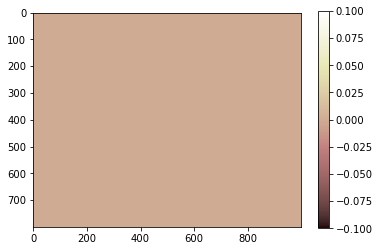

In [17]:
plt.imshow(normalized_uint8(GRVI_func(image), nan_val = np.nan), cmap = 'pink')
plt.colorbar()

### Compute grayscale image

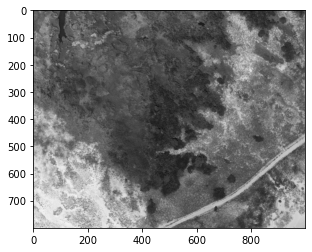

In [18]:
im_gray = gray_func(image)
plt.imshow(im_gray, cmap='gray')

### Use rasterio to read small ortho for use as a template

In [19]:
rds = rio.open_rasterio(out_dir+ortho_fname)
rds

<xarray.DataArray (band: 3, y: 800, x: 1000)>
[2400000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3
  * x            (x) float64 3.945e+05 3.945e+05 ... 3.947e+05 3.947e+05
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.871e+06 3.871e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### Build a composite image with grayscale, veg index, and elevation

In [20]:
rds[0,:,:]=im_gray
rds[1,:,:]=GRRI_n
rds[2,:,:]=eln

### Esport as a .tiff file

In [21]:
composite_basename = 'composite'
rds.rio.to_raster(out_dir+composite_basename+'.tif')

### Use gdal to convert from tiff to jpeg

In [23]:
gdal_cmd = 'gdal_translate -of JPEG -b 1 -b 2 -b 3 {}.tif {}.jpg'.format(
    out_dir+composite_basename, out_dir+composite_basename)
print(gdal_cmd)
if os.system(gdal_cmd)==0:
    print('Success')
os.system('gdalinfo '+out_dir+composite_basename+'.jpg')

gdal_translate -of JPEG -b 1 -b 2 -b 3 C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/jpeg_composites/composite.tif C:/crs/proj/2022_Composite_Experiment/Composite_Experiment/jpeg_composites/composite.jpg
Success


0